<a href="https://colab.research.google.com/github/jlovechae/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)

        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)

                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')

                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [6]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [7]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [8]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.

## 14-5 의류 이미지 여부 판단

In [9]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? Must say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image can be considered a picture of clothing. It features a man wearing what appears to be a coordinated outfit consisting of a jacket and pants in the same color scheme. The focus on the attire suggests that it may be used for fashion or retail purposes, showcasing how the garments look when worn.
Yes, this image appears to be a picture of clothing. It showcases two individuals wearing coordinated outfits that seem to be part of a fashion collection or lookbook. The setting and styling suggest that the focus is on presenting these garments in a visually appealing manner, likely for promotional purposes such as an advertisement or a catalog.
No, this image is not of clothing. It appears to be a book cover or some form of printed material with the title "Transcripts of a Sea." The design elements such as the distressed paper texture and the ink blot effect suggest that it could be related to literature, poetry, or an artistic project rather than clothing.
No, this image is no

## 14-6 의류 판단 결과 시각화

In [10]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,False
3,,False
4,,True
5,,False
6,,True
7,,True
8,,True
9,,True


## 14-7 의류 이미지 필터링

In [11]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]
df

,image,is_clothing
0,https://glltn.com/wp-content/blogs.dir/1/files...,True
1,https://glltn.com/wp-content/blogs.dir/1/files...,True
4,https://glltn.com/wp-content/blogs.dir/1/files...,True
6,https://glltn.com/wp-content/blogs.dir/1/files...,True
7,https://glltn.com/wp-content/blogs.dir/1/files...,True
8,https://glltn.com/wp-content/blogs.dir/1/files...,True
9,https://glltn.com/wp-content/blogs.dir/1/files...,True
10,https://glltn.com/wp-content/blogs.dir/1/files...,True
11,https://glltn.com/wp-content/blogs.dir/1/files...,True


In [12]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
4,,True
6,,True
7,,True
8,,True
9,,True
10,,True
11,,True


## 14-8 의류 스타일 분석

In [13]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)
df

/tmp/ipython-input-2660753284.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


,image,is_clothing,style
0,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...
1,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes worn by both individu...
4,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image reflects...
6,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...
7,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the shoes depicted in the image i...
8,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...
9,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image reflects...
10,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image leans to...
11,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image leans to...


In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image suggests a casual, possibly outdoor-oriented fashion. The brown color of the jacket and pants is earthy and subdued, which often indicates an intention to blend with natural environments or for a minimalist aesthetic. This color choice can be seen as timeless and versatile, suitable for various seasons and settings.\n\nIn terms of trend changes, such clothing might suggest a preference for comfort over formality, which has been a growing trend in contemporary fashion. The textured pattern on the jacket adds visual interest without being overly flashy, indicating a subtle embrace of trendy details that still maintain a sense of understatement.\n\nOverall, the outfit reflects a practical and stylish approach to dressing, likely chosen for both functionality and personal expression. It avoids bold colors or patterns, opting instead for a classic look that could appeal to those who favor simplicity and elegance in their attire."
1,,True,"The style of the clothes worn by both individuals in the image leans towards a minimalist and casual aesthetic, which is characterized by simplicity, comfort, and an understated elegance. The use of neutral colors such as beige, grey, and burgundy suggests a preference for versatile pieces that can be easily mixed and matched.\n\nFor the individual on the left, the combination of a red cardigan with a grey shirt and beige shorts creates a balanced look that plays with color contrasts without being overly bold. Red is often associated with energy and passion, while grey provides a calm and neutral backdrop, balancing the vibrancy of the red. Beige shorts add to the earthy tones, contributing to a cohesive and harmonious outfit.\n\nOn the right, the choice of a light grey cardigan over a grey shirt paired with matching shorts demonstrates a trend towards monochromatic outfits, where different shades of one color are used together. This creates a sense of unity and sophistication. The relaxed fit of the clothing items indicates a preference for comfort, aligning with contemporary fashion trends that prioritize ease of movement and personal expression over restrictive or form-fitting garments.\n\nOverall, the attire reflects a modern, laid-back style that emphasizes comfort, versatility, and subtle elegance, likely appealing to those who value practicality and understated fashion sensibilities."
4,,True,"The style of the clothes in the image reflects a modern, minimalist aesthetic that is often associated with contemporary fashion trends. The color palette is monochromatic and subdued, featuring shades of gray which are versatile and can convey a sense of sophistication and understated elegance. This choice of color suggests a preference for classic pieces that can be easily integrated into various outfits.\n\nThe oversized blazer is indicative of a trend where clothing items have been loosened to create a more relaxed fit. This trend has been popular in recent years as it offers comfort and a laid-back look while still maintaining a polished appearance. The lack of visible branding or embellishments on the garment aligns with a broader movement towards minimalism in fashion, where simplicity and function take precedence over conspicuous consumption.\n\nOverall, the outfit presented in the image seems designed to appeal to those who favor timeless styles that are both functional and fashionable, embodying a blend of casual ease and refined taste."
6,,True,"The style of the clothes in the image suggests a casual, streetwear-inspired look that is both comfortable and fashionable. The mint green hoodie with ""ARM"" printed on it has a relaxed fit, which is characteristic of contemporary casual wear. Hoodies have become a staple in men's fashion due to their versatility and comfort, often seen as a layering piece or a standalone item.\n\nThe light blue denim shirt adds a classic touch to the ensemble, contrasting with the modernity of

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [16]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model = 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 11-23 12:45:38 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-23 12:45:39 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-23 12:45:57 config.py:549] This model supports multiple tasks: {'score', 'reward', 'embed', 'classify', 'generate'}. Defaulting to 'generate'.
INFO 11-23 12:45:57 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-23 12:46:01 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-23 12:46:01 cuda.py:226] Using XFormers backend.
INFO 11-23 12:46:02 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-23 12:46:02 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-23 12:48:20 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 137.880805 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-23 12:49:00 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-23 12:49:03 worker.py:267] Memory profiling takes 2.38 seconds
INFO 11-23 12:49:03 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-23 12:49:03 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-23 12:49:03 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-23 12:49:03 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-23 12:49:10 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:41<00:00,  1.19s/it]

INFO 11-23 12:49:52 model_runner.py:1562] Graph capturing finished in 42 secs, took 0.21 GiB
INFO 11-23 12:49:52 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 52.08 seconds


## 14-10 색상 정보 추출

In [17]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-23 12:52:56 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, est. speed input: 1009.16 toks/s, output: 8.44 toks/s]


갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s, est. speed input: 762.24 toks/s, output: 32.73 toks/s]


- beige
- grey
- burgundy
- red


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s, est. speed input: 2322.43 toks/s, output: 18.58 toks/s]


회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, est. speed input: 505.34 toks/s, output: 37.18 toks/s]


**색상:**
- 민트 그린 (Mint Green)
- 라이트 블루 (Light Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, est. speed input: 991.79 toks/s, output: 32.38 toks/s]


색상: muted brown / taupe


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s, est. speed input: 776.91 toks/s, output: 33.41 toks/s]


**색상:**
- 갈색
- 어두운 톤


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s, est. speed input: 970.69 toks/s, output: 32.65 toks/s]


- **파란색**
- **베이지**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, est. speed input: 718.42 toks/s, output: 35.28 toks/s]


**색상:**
- **올리브 그린**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, est. speed input: 562.76 toks/s, output: 36.12 toks/s]

**색상:**
- 베이지 (Beige)
- 카키 (Khaki)



/tmp/ipython-input-1327615383.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [19]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해 주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요. \n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s, est. speed input: 245.47 toks/s, output: 38.87 toks/s]


- 캐주얼한 스타일
- 자연 친화적
- 미니멀리스트
- 시간 초월적
- 편안함 중시
- 실용적
- 개인 표현
- 클래식한 룩


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 124.58 toks/s, output: 40.77 toks/s]


- **미니멀리즘**
- **캐주얼**
- **심플함**
- **편안함**
- **무채색** (베이지, 그레이, 버건디)
- **균형**
- **색상 대조**
- **에너지**
- **차분함**
- **조화로움**
- **단색**
- **통일감**
- **편안함**
- **현대적**
- **편안한 움직임**
- **개인 표현**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, est. speed input: 295.80 toks/s, output: 40.07 toks/s]


- 현대적 미니멀리즘
- 단색
- 회색조
- 클래식
- 루즈핏
- 편안함
- 단순함
- 기능성 중시


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it, est. speed input: 235.85 toks/s, output: 40.09 toks/s]


- 캐주얼
- 스트리트웨어
- 편안함
- 패션성
- 민트 그린
- ARM
- 루즈핏
- 레이어드
- 클래식
- 데님
- timelessness
- 색상 조화
- 부드러운 톤
- 단순함


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, est. speed input: 283.28 toks/s, output: 40.30 toks/s]


- 클래식
- timeless
- 캐주얼
- 스타일리시
- 다양성
- 실용성
- 패션
- 편안함
- 현대적
- 빈티지


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it, est. speed input: 170.27 toks/s, output: 40.74 toks/s]


- 편안함
- 따뜻함
- coziness
- 캐주얼 엘레강스
- 소프트 플리스 소재
- faux fur
- 중립적인 톤 (갈색, 어두운 색상)
- 계절적 적합성
- 트렌드 변화 (재부상)
- 편안함과 스타일의 조화
- 미니멀리즘


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, est. speed input: 191.25 toks/s, output: 40.82 toks/s]


- 캐주얼
- relaxed
- 스트리트웨어
-Urban 패션
- 클래식
- 내구성
- 다양성
- 데님
- 미니멀리즘
- 단순함
- 깊이감
- 현대적
- 편안함
- 기능성
- 기본적
- 실용성
- 지속가능성
- 버킷햇


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, est. speed input: 245.98 toks/s, output: 40.45 toks/s]


- 군사적 스타일
- 실용적 디자인
- 올리브 그린
- 오버사이즈
- 빈티지 현대적 해석
- 기능성
- 내구성
- 역사적 영향


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, est. speed input: 151.92 toks/s, output: 39.39 toks/s]

- **미니멀리즘**
- **실용주의**
- **중립톤**
- **오버스IZE**
- **편안함**
- **기능성**
- **텍스처**
- **깊이**
- **심플함**
- **믹스매치**
- **현대적**
- **성별중립**



/tmp/ipython-input-13121270.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [20]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image suggests a casual, possibly outdoor-oriented fashion. The brown color of the jacket and pants is earthy and subdued, which often indicates an intention to blend with natural environments or for a minimalist aesthetic. This color choice can be seen as timeless and versatile, suitable for various seasons and settings.\n\nIn terms of trend changes, such clothing might suggest a preference for comfort over formality, which has been a growing trend in contemporary fashion. The textured pattern on the jacket adds visual interest without being overly flashy, indicating a subtle embrace of trendy details that still maintain a sense of understatement.\n\nOverall, the outfit reflects a practical and stylish approach to dressing, likely chosen for both functionality and personal expression. It avoids bold colors or patterns, opting instead for a classic look that could appeal to those who favor simplicity and elegance in their attire.",갈색,- 캐주얼한 스타일\n- 자연 친화적\n- 미니멀리스트\n- 시간 초월적\n- 편안함 중시\n- 실용적\n- 개인 표현\n- 클래식한 룩
1,,True,"The style of the clothes worn by both individuals in the image leans towards a minimalist and casual aesthetic, which is characterized by simplicity, comfort, and an understated elegance. The use of neutral colors such as beige, grey, and burgundy suggests a preference for versatile pieces that can be easily mixed and matched.\n\nFor the individual on the left, the combination of a red cardigan with a grey shirt and beige shorts creates a balanced look that plays with color contrasts without being overly bold. Red is often associated with energy and passion, while grey provides a calm and neutral backdrop, balancing the vibrancy of the red. Beige shorts add to the earthy tones, contributing to a cohesive and harmonious outfit.\n\nOn the right, the choice of a light grey cardigan over a grey shirt paired with matching shorts demonstrates a trend towards monochromatic outfits, where different shades of one color are used together. This creates a sense of unity and sophistication. The relaxed fit of the clothing items indicates a preference for comfort, aligning with contemporary fashion trends that prioritize ease of movement and personal expression over restrictive or form-fitting garments.\n\nOverall, the attire reflects a modern, laid-back style that emphasizes comfort, versatility, and subtle elegance, likely appealing to those who value practicality and understated fashion sensibilities.",- beige\n- grey\n- burgundy\n- red,"- **미니멀리즘**\n- **캐주얼**\n- **심플함**\n- **편안함**\n- **무채색** (베이지, 그레이, 버건디)\n- **균형**\n- **색상 대조**\n- **에너지**\n- **차분함**\n- **조화로움**\n- **단색**\n- **통일감**\n- **편안함**\n- **현대적**\n- **편안한 움직임**\n- **개인 표현**"
4,,True,"The style of the clothes in the image reflects a modern, minimalist aesthetic that is often associated with contemporary fashion trends. The color palette is monochromatic and subdued, featuring shades of gray which are versatile and can convey a sense of sophistication and understated elegance. This choice of color suggests a preference for classic pieces that can be easily integrated into various outfits.\n\nThe oversized blazer is indicative of a trend where clothing items have been loosened to create a more relaxed fit. This trend has been popular in recent years as it offers comfort and a laid-back look while still maintaining a polished appearance. The lack of visible branding or embellishments on the garment aligns with a broader movement towards minimalism in fashion, where simplicity and function take precedence over conspicuous consumption.\n\nOverall, the outfit presented in the image seems designed to appeal to those who favor timeless styles that are both functional and fashionable, embodying a blend of casual ease and refined taste.",회색,- 현대적 미니멀리즘\n- 단색\n- 회색조\n- 클래식\n- 루즈핏\n- 편안함\n- 단순함\n- 기능성 중시
6,,True,"The style of the clothes in the image suggests a casual, streetwear-inspired look that

## 14-12 텍스트 데이터 정제

In [21]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

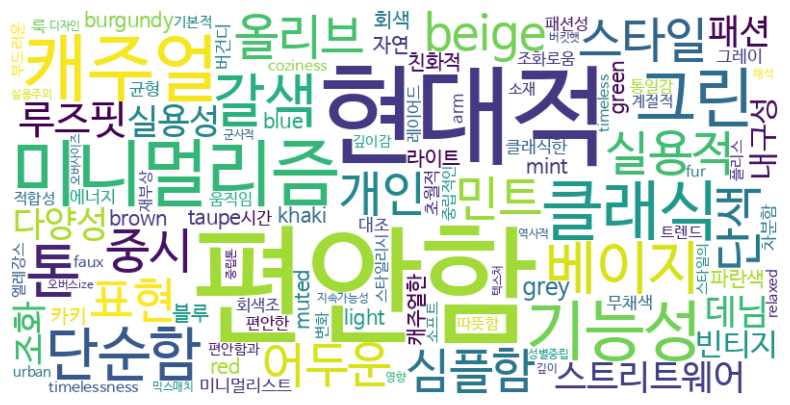

In [22]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [25]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": """
주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요.
보고서의 제목은 해외 록북 스타일분석입니다.
내용은 전문적이면서 명확하게 작성해주세요.
문서형식은 마크다운입니다.
예시 이미지를 적절한 곳에 추가해서 바로 볼 수 있도록 해주세요.
"""
})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:25<00:00, 25.72s/it, est. speed input: 106.29 toks/s, output: 39.77 toks/s]


In [26]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 록북 스타일 분석 보고서

## 개요
본 보고서는 최근 패션 트렌드 분석을 통해 도출된 록북 스타일의 특징과 주요 트렌드를 종합적으로 조명합니다. 다양한 이미지와 함께 제시된 스타일 노트를 바탕으로, 현대 패션에서 관찰되는 주요 경향과 그 배경을 분석합니다.

## 트렌드 분석

### 1. **실용성과 편안함의 융합**
- **스타일 예시**: 
  - **이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/johnbull-fall-winter-2025-collection-lookbook-01-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/johnbull-fall-winter-2025-collection-lookbook-01-1024x683.jpg)
  - **분석**: 편안함과 실용성이 강조되는 의류가 주요 트렌드로 부상하고 있습니다. 예를 들어, oversized hoodies와 relaxed fit jeans는 일상 생활에서의 편안함과 동시에 스타일리시한 외관을 제공합니다.

### 2. **미니멀리즘과 클래식의 조화**
- **스타일 예시**:
  - **이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/undecorated-fall-winter-2025-collection-lookbook-13-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/undecorated-fall-winter-2025-collection-lookbook-13-1024x683.jpg)
  - **분석**: 미니멀한 디자인과 클래식한 소재의 조합이 인기입니다. 중성적인 색상 팔레트와 단순한 패턴은 현대적인 감각을 유지하면서도 오래 지속될 수 있는 패션 아이템을 제공합니다.

### 3. **군사적 요소와 현대적 해석**
- **스타일 예시**:
  - **이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/warobe-fall-winter-2025-collection-lookbook-08-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/warobe-fall-winter-2025-collection-lookbook-08-1024x683.jpg)
  - **분석**: 군사적 요소가 현대 패션에 재해석되고 있습니다. 실용적인 디자인과 기능성을 유지하면서도, 독특한 디테일과 색상 조합으로 개성을 표현합니다.

### 4. **스트리트웨어와 캐주얼의 융합**
- **스타일 예시**:
  - **이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/omnigod-fall-winter-2025-collection-lookbook-09-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/omnigod-fall-winter-2025-collection-lookbook-09-1024x683.jpg)
  - **분석**: 스트리트웨어의 편안함과 캐주얼한 스타일이 결합되어 일상과 특별한 순간 모두에 적합한 패션을 제공합니다. 다양한 액세서리와의 조화를 통해 개성과 실용성을 동시에 추구합니다.

## 결론
현대 패션 트렌드는 실용성과 편안함을 중시하면서도, 미니멀리즘과 클래식한 디자인 요소를 통해 세련됨을 유지하고 있습니다. 군사적 요소와 스트리트웨어의 융합은 개성 표현과 기능성 사이의 균형을 찾아가는 과정을 보여줍니다. 이러한 경향은 소비자들이 일상 생활에서의 편안함과 동시에 개인적인 스타일을 추구하는 경향을 반영하고 있습니다. 이러한 분석은 패션 디자이너와 소비자 모두에게 유용한 지침을 제공하며, 미래의 패션 트렌드를 예측하는 데 도움이 될 것입니다.